In [1]:
import pandas as pd
import numpy as np
import json
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

from utils import (
    save_as_json,
    # rgba_to_hex,
    # convert_rgba_to_hex,
    get_graph_from_matrix_customized_color,
    # get_graph_from_cluster_data,
    append_cluster_color,
    get_cluster_plot,
    # get_correlation_df_per_cluster,
    get_graph_from_cluster_data_without_color,
    get_cluster_overview,
    append_mean_coefficients_per_cluster,
    get_mean_sentiment_corr,
)

pd.set_option("display.max_colwidth", None)

matrix = pd.read_json(
    "../graph_network/plots_graphs_or_dfs_archive/matrix_iv_29-04-24.json"
)
graph_clustering_shortest_path = pd.read_json("../graph_network/graph_clustering_shortest_path_03-05-24.json")
graph_clustering_e_b_c = pd.read_json("../graph_network/graph_clustering_edge_betweenness_centrality_03-05-24.json")
url_clustering_2 = pd.read_json("../graph_network/url_clustering_2_04-05-24.json")
url_clustering_3 = pd.read_json("../graph_network/url_clustering_3_04-05-24.json")

In [2]:
senti = pd.read_json("../graph_network/full_data_iv_29-04-24.json")

In [2]:
G, N = get_graph_from_matrix_customized_color(matrix)
N.show("graph_sentiment_coloring_iv.html")

# Clustering based on Shortest-Path

### Function demonstration using the Karate Club graph  

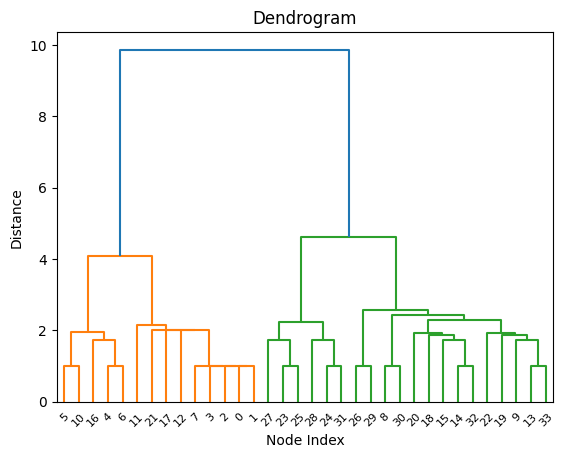

In [17]:
G = nx.karate_club_graph()

path_lengths = dict(nx.all_pairs_shortest_path_length(G))
distance_matrix = np.zeros((len(G), len(G)))

nodes = list(G.nodes())
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes):
        if node_j in path_lengths[node_i]:
            distance_matrix[i, j] = path_lengths[node_i][node_j]

linked = linkage(squareform(distance_matrix), method='ward')

dendrogram(linked)

# Dendrogram anzeigen
plt.title("Dendrogram")
plt.xlabel('Node Index')
plt.ylabel('Distance')
plt.show()


In [4]:
G = G.to_undirected()
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [5]:
path_lengths = dict(nx.all_pairs_shortest_path_length(G))
distance_matrix = np.zeros((len(G), len(G)))

nodes = list(G.nodes())
for i, node_i in enumerate(nodes):
    for j, node_j in enumerate(nodes):
        if node_j in path_lengths[node_i]:
            distance_matrix[i, j] = path_lengths[node_i][node_j]

linked = linkage(squareform(distance_matrix), method='ward')

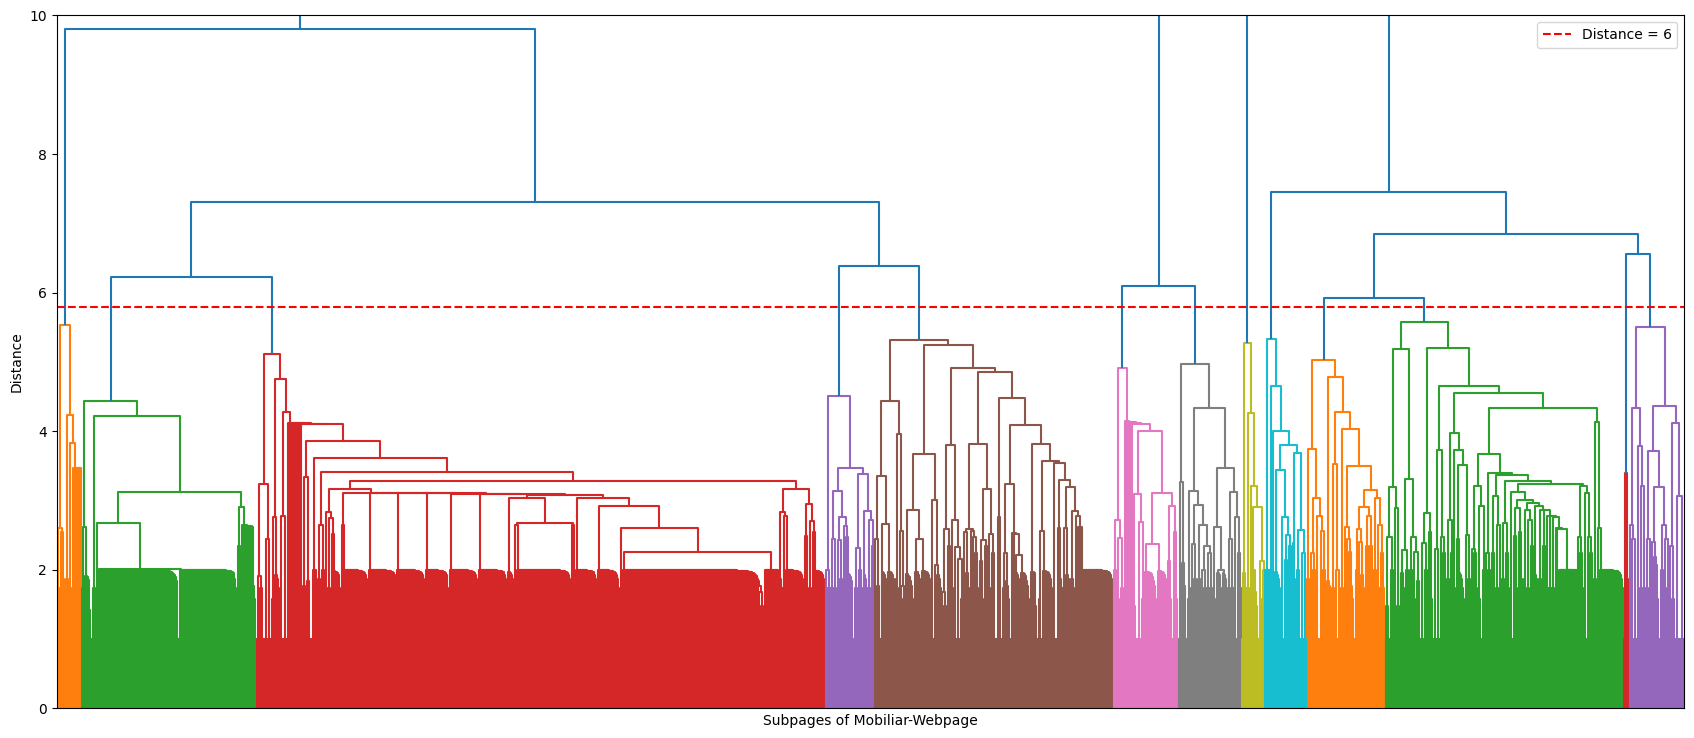

In [19]:
fig, ax = plt.subplots(figsize=(21, 9))
dendrogram(linked, ax=ax, color_threshold=6)
ax.set_ylim(0, 10)
ax.set_xticks([])
ax.axhline(y=6, color='r', linestyle='--', label='Distance = 6')
plt.xlabel('Subpages of Mobiliar-Webpage')
ax.set_ylabel('Distance')
# plt.title('Full Dendrogram of Hierarchical Linkage Clustering')
ax.legend()
plt.show()

In [ ]:
max_distance = 6
cluster_labels = fcluster(linked, max_distance, criterion='distance')
node_to_cluster = {node: int(cluster) for node, cluster in zip(nodes, cluster_labels)}

In [8]:
graph_clustering_shortest_path = senti.copy()
graph_clustering_shortest_path['cluster_id'] = graph_clustering_shortest_path['url'].map(node_to_cluster)

### Coloring

In [3]:
print("Rows count:", graph_clustering_shortest_path.shape[0])
graph_clustering_shortest_path = graph_clustering_shortest_path.dropna(subset=["cluster_id"])
print("Rows count:", graph_clustering_shortest_path.shape[0])

Rows count: 1718
Rows count: 1718


In [14]:
df = get_cluster_overview(graph_clustering_shortest_path, "cluster_id").sort_values("cluster_size", ascending=False)
df

Number of Clusters that we can calculate the correlation: 12 
 containing: 1718 Pages/Nodes.


,index,cluster_id,avg_neg,avg_neu,avg_pos,cluster_size,color_cluster_id
4,493,5,0.296175,0.145904,0.557921,620,#f5e505
9,1323,10,0.395900,0.158113,0.445987,317,#05f531
2,66,3,0.279379,0.155789,0.564832,243,#f50515
3,309,4,0.387489,0.114738,0.497773,184,#2d05f7
11,1646,12,0.419981,0.180308,0.399711,72,#7c02f5
5,1113,6,0.386005,0.152469,0.461525,69,#f5a505
6,1182,7,0.383331,0.162421,0.454247,67,#c20aff
8,1273,9,0.367054,0.182843,0.450102,50,#4a1a1a
1,22,2,0.267896,0.134429,0.597675,44,#02eff7
7,1249,8,0.384700,0.190446,0.424854,24,#144026


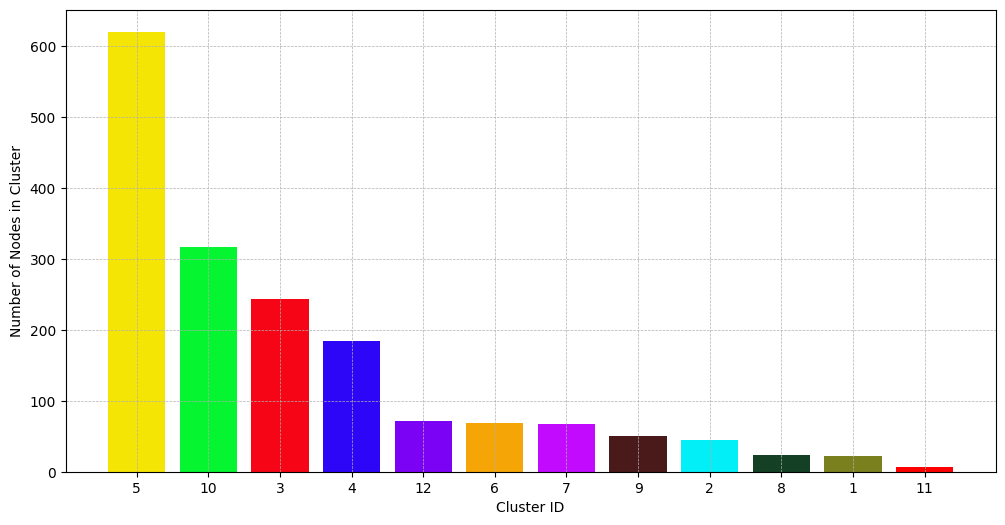

In [15]:
get_bar_plot(df, "cluster_id")

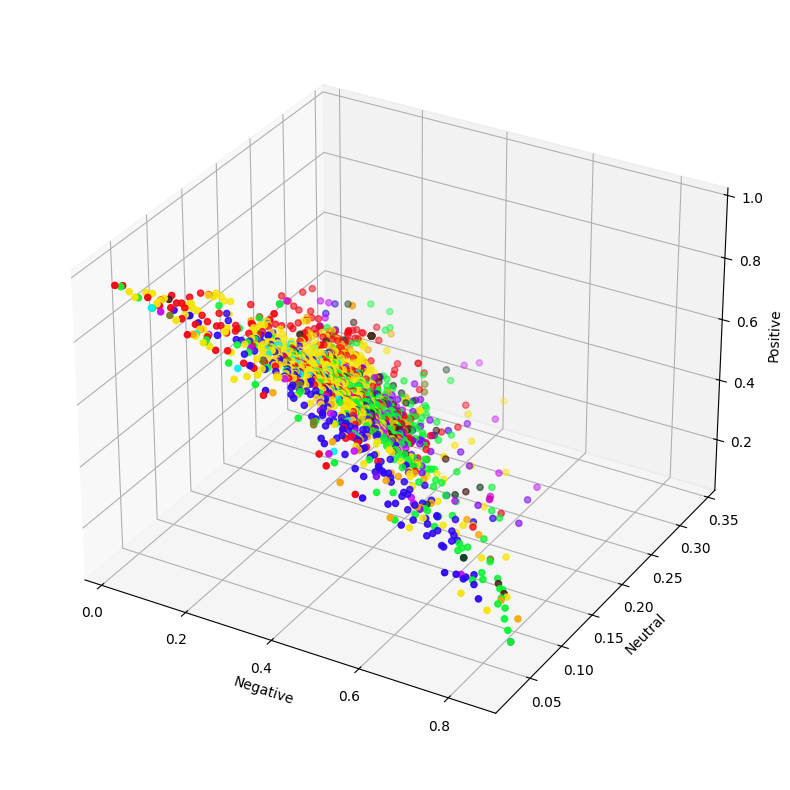

In [21]:
# specific_colors = {
#     # 1: "red", 2: "green", 3: "blue", 4: "yellow", 5: "orange", 6: "purple", 7:"winered"
#     5: "#f5e505", 10: "#05f531", 3: "#f50515", 4: "#2d05f7", 12: "#7c02f5", 6: "#f5a505", 7:"#c20aff", 9:"#4a1a1a", 2:"#02eff7", 8:"#144026", 1:"#79801d"
    
# }
# append_cluster_color(graph_clustering_shortest_path, "cluster_id", specific_colors)
get_cluster_plot(graph_clustering_shortest_path, "cluster_id")

In [14]:
# save_as_json(graph_clustering_shortest_path, "graph_clustering_shortest_path")

### Create Graph

In [94]:
# G, N = get_graph_from_cluster_data(matrix, graph_clustering_shortest_path, "cluster_id")
# graph_clustering_shortest_path = pd.read_json("../graph_network/graph_clustering_shortest_path_04-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, graph_clustering_shortest_path, "cluster_id") 
N.show("graph_clustering_shortest_path.html")

### Stats

In [6]:
graph_clustering_shortest_path["cluster_id"].nunique()

12

In [6]:
correlation_of_mean_sentiment_per_cluster, correlation_matrix_per_cluster = get_correlation_df_per_cluster(graph_clustering_shortest_path, "cluster_id")
correlation_of_mean_sentiment_per_cluster

Number of Clusters that we can calculate the correlation: 12 
 containing: 1718 Pages/Nodes.


,avgc_negative,avgc_neutral,avgc_positive
avgc_negative,1.000000,0.169142,-0.905020
avgc_neutral,0.169142,1.000000,-0.572318
avgc_positive,-0.905020,-0.572318,1.000000


In [7]:
get_cluster_overview(graph_clustering_shortest_path, "cluster_id")

negative   neutral  positive
cluster_id                                       
1.0        negative  1.000000  0.237430 -0.932031
           neutral   0.237430  1.000000 -0.573308
           positive -0.932031 -0.573308  1.000000
2.0        negative  1.000000  0.478657 -0.938822
           neutral   0.478657  1.000000 -0.751760
           positive -0.938822 -0.751760  1.000000
3.0        negative  1.000000  0.313914 -0.935650
           neutral   0.313914  1.000000 -0.628803
           positive -0.935650 -0.628803  1.000000
4.0        negative  1.000000 -0.178104 -0.982197
           neutral  -0.178104  1.000000 -0.009914
           positive -0.982197 -0.009914  1.000000
5.0        negative  1.000000  0.315738 -0.953984
           neutral   0.315738  1.000000 -0.585727
           positive -0.953984 -0.585727  1.000000
6.0        negative  1.000000 -0.435684 -0.934977
           neutral  -0.435684  1.000000  0.088082
           positive -0.934977  0.088082  1.000000
7.0        negative  1.000000  0.038135 -0.917398
           neutral   0.038135  1.000000 -0.432667
           positive -0.917398 -0.432667  1.000000
8.0        negative  1.000000 -0.661925 -0.951455
           neutral  -0.661925  1.000000  0.399084
           positive -0.951455  0.399084  1.000000
9.0        negative  1.000000 -0.442587 -0.940878
           neutral  -0.442587  1.000000  0.112658
           positive -0.940878  0.112658  1.000000
10.0       negative  1.000000 -0.182628 -0.949371
           neutral  -0.182628  1.000000 -0.135492
           positive -0.949371 -0.135492  1.000000
11.0       negative  1.000000 -0.940369 -0.962970
           neutral  -0.940369  1.000000  0.813838
           positive -0.962970  0.813838  1.000000
12.0       negative  1.000000 -0.444457 -0.944268
           neutral  -0.444457  1.000000  0.124809
           positive -0.944268  0.124809  1.000000

## Edge betweenness centrality - Girvan Newman Algorithm

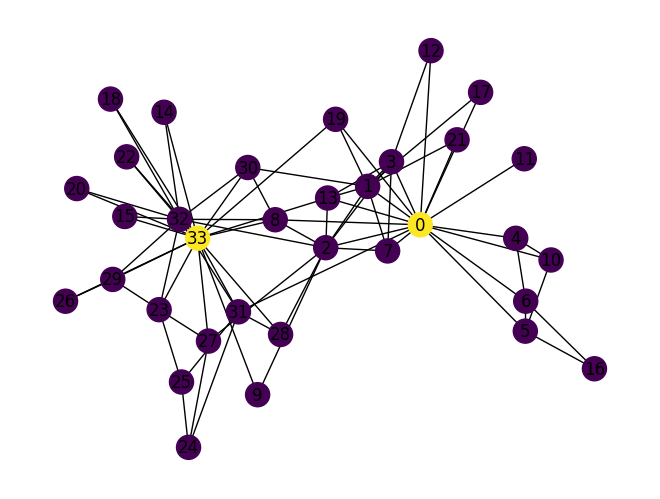

In [10]:
import networkx as nx
from sklearn.cluster import KMeans
import numpy as np

# Erstellen Sie Ihren Graphen
G = nx.karate_club_graph()

# Berechnen Sie die Betweenness Centrality für jeden Knoten
centrality = nx.betweenness_centrality(G)
centrality_values = np.array(list(centrality.values())).reshape(-1, 1)

# Anwendung eines Clustering-Algorithmus, hier k-means
kmeans = KMeans(n_clusters=2)
kmeans.fit(centrality_values)
labels = kmeans.labels_

# Knotenlabels zuordnen und den Graphen visualisieren
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color=labels, with_labels=True, cmap='viridis')


In [73]:
G = G.to_undirected()
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [74]:
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G)
    return max(centrality, key=centrality.get)

k = 20
comp = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge)

limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    tuple(sorted(c) for c in communities)

({'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/bau-und-gebaeude', 'https://www.mobiliar.ch/news/schnee-zerstoert-kirschbaeume-ein-jahr-danach', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/vorsorge-und-gesundheit/unsere-vorsorgeprodukte/vorausschauende-sparversicherung/beratungsanfrage-vorausschauende-sparversicherung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/datenschutz-und-sicherheit/datenschutzerklaerung-fuer-die-schadenfallbearbeitung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/kundenzufriedenheit', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/unfall-und-krankheit/leistungsuebersicht-ueber-die-obligatorische-unfallversicherung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/fahrzeuge-und-transport/transportversicherung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen/berufliche-vorsorge/newsletter-berufliche-vorsorge/fi

In [75]:
community_id = {node: idx for idx, community in enumerate(communities) for node in community}

In [ ]:
# DENDOGRAM maybe here:
# https://stackoverflow.com/questions/59821151/plot-the-dendrogram-of-communities-found-by-networkx-girvan-newman-algorithm

#113 min timeout

In [76]:
graph_clustering_e_b_c = senti.copy()
graph_clustering_e_b_c['commun_id'] = senti['url'].map(community_id)

### Coloring

In [6]:
print("Rows count:", graph_clustering_e_b_c.shape[0])
graph_clustering_e_b_c = graph_clustering_e_b_c.dropna(subset=["commun_id"])
print("Rows count:", graph_clustering_e_b_c.shape[0])

Rows count: 1718
Rows count: 1718


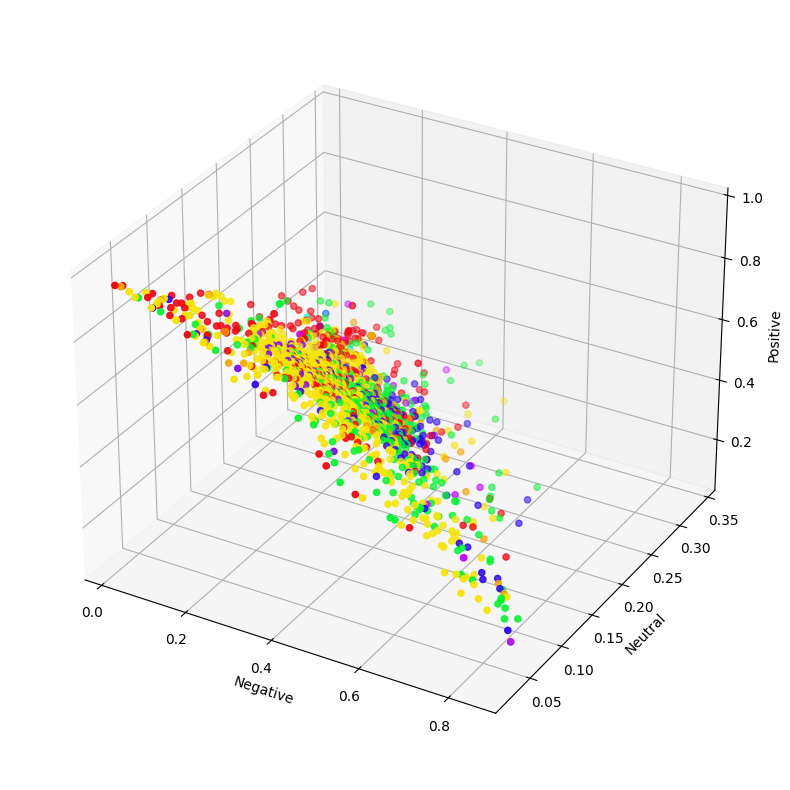

In [29]:
# specific_colors = {
#     5: "#f5e505", 0: "#05f531", 7: "#f50515", 2: "#2d05f7", 8: "#7c02f5", 1: "#f5a505", 4:"#c20aff"
# }
# append_cluster_color(graph_clustering_e_b_c, "commun_id",specific_colors)
get_cluster_plot(graph_clustering_e_b_c, "commun_id")

### Create Graph

In [3]:
# save_as_json(graph_clustering_e_b_c, "graph_clustering_edge_betweenness_centrality")
graph_clustering_e_b_c = pd.read_json("../graph_network/graph_clustering_edge_betweenness_centrality_03-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, graph_clustering_e_b_c, "commun_id") 
N.show("graph_clustering_edge_betweenness_centrality.html")

### Stats

In [6]:
df = get_cluster_overview(graph_clustering_e_b_c, "commun_id").sort_values("commun_size", ascending=False)
df

Number of Clusters that we can calculate the correlation: 15 
 containing: 1713 Pages/Nodes.


,index,commun_id,avg_neg,avg_neu,avg_pos,commun_size,color_commun_id
5,608,5,0.316928,0.138221,0.544851,788,#f5e505
0,0,0,0.392429,0.156444,0.451127,365,#05f531
7,1398,7,0.283526,0.155182,0.561292,248,#f50515
2,448,2,0.414799,0.167972,0.417229,129,#2d05f7
1,365,1,0.363244,0.176019,0.460737,83,#f5a505
8,1646,8,0.268707,0.137373,0.593920,53,#7c02f5
4,581,4,0.399047,0.183700,0.417253,27,#c20aff
3,577,3,0.291499,0.211805,0.496696,4,#ff0000
9,1699,9,0.378260,0.185048,0.436692,4,#ffe600
6,1396,6,0.203590,0.097678,0.698732,2,#ff7000


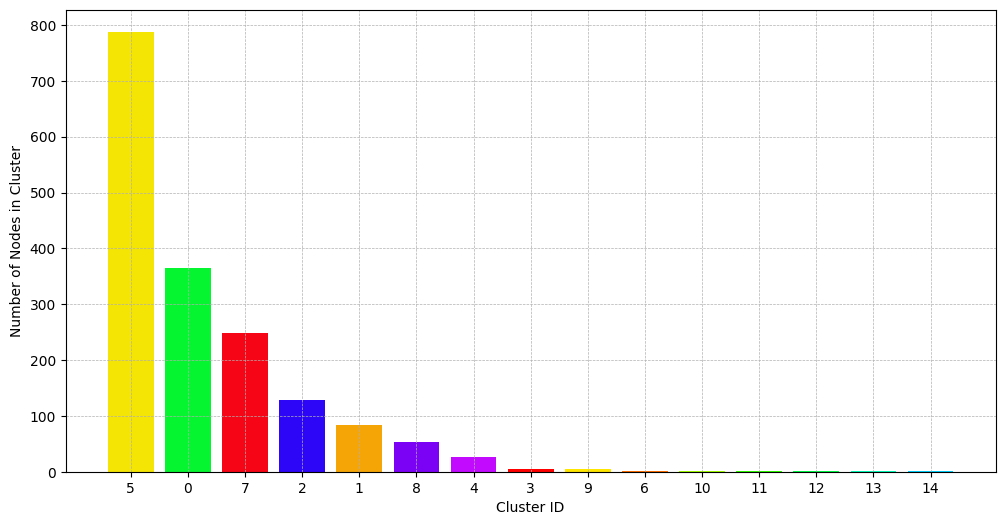

In [12]:
def get_bar_plot(df, cluster_col):  
    plt.figure(figsize=(12, 6))  # Größe des Plots festlegen
    plt.bar(df[cluster_col].astype(str), df[f'{cluster_col[:-3]}_size'], color=df[f"color_{cluster_col}"])
    plt.xlabel(f'Number of Nodes in Cluster') #{cluster_col[:-3]}
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax = plt.gca()
    plt.xlabel('Cluster ID') 
    plt.ylabel(f'Number of Nodes in Cluster')
    plt.show()

get_bar_plot(df, "commun_id")

In [80]:
graph_clustering_e_b_c["commun_id"].nunique()
correlation_of_mean_sentiment_per_cluster, correlation_matrix_per_cluster = get_correlation_df_per_cluster(graph_clustering_e_b_c, "commun_id")
correlation_of_mean_sentiment_per_cluster

Number of Clusters that we can calculate the correlation: 15 
 containing: 1713 Pages/Nodes.


,avgc_negative,avgc_neutral,avgc_positive
avgc_negative,1.000000,-0.136827,-0.848521
avgc_neutral,-0.136827,1.000000,-0.408084
avgc_positive,-0.848521,-0.408084,1.000000


In [15]:
get_cluster_overview(graph_clustering_e_b_c, "commun_id")

NameError: name 'get_average_sentiment_and_size_per_cluster' is not defined

# URL Clustering

### Helper Functions

In [2]:
def get_url_path(url):
    from urllib.parse import urlparse
    parsed_url = urlparse(url)
    return parsed_url.path, parsed_url.netloc

def get_url_list(url):
    path, domain = get_url_path(url.strip("/"))
    url_elements = [domain] 
    if path:
        url_elements.extend(x.strip() for x in path.split("/") if x.strip())  
    return url_elements

def append_url_list_to_df(df, url_col="url"):
    df["url_elements_list"] = df[url_col].apply(get_url_list)
    return df 
    
def get_list_length(df, url_list_col):
    df['list_length'] = df[url_list_col].apply(len)
    return df

senti = append_url_list_to_df(senti)

NameError: name 'senti' is not defined

In [60]:
def group_by_list_element(df, column_name, position):
    df_copy = df.copy()
    element_groups = {}
    df_copy["group_id"] = df.index
    unique_group_id = 1  # Startwert für Gruppen-IDs

    for idx, row in df_copy.iterrows():
        # Prüfen, ob die Liste lang genug ist
        if position < len(row[column_name]):
            # Erstellen eines Tupels der Elemente bis zur angegebenen Position
            current_elements = tuple(row[column_name][:position + 1])
            if current_elements in element_groups:
                new_group_id = element_groups[current_elements]
            else:
                new_group_id = unique_group_id
                element_groups[current_elements] = new_group_id
                unique_group_id += 1  # Erhöhe den Zähler für Gruppen-IDs
        else:
            # Falls die Liste kürzer ist, als die geforderte Position,
            # weisen wir eine neue, eindeutige Gruppen-ID zu
            new_group_id = unique_group_id
            unique_group_id += 1  # Erhöhe den Zähler für Gruppen-IDs

        df_copy.at[idx, "group_id"] = new_group_id

    return df_copy

### Clustering

In [79]:
url_clustering_1 = group_by_list_element(senti, "url_elements_list", 1)
url_clustering_2 = group_by_list_element(senti, "url_elements_list", 2)
url_clustering_3 = group_by_list_element(senti, "url_elements_list", 3)

# url_clustering_3["group_id"].nunique()

In [71]:
url_clustering_ = group_by_list_element(senti, "url_elements_list", 1)
url_clustering_["group_id"].nunique()

1746

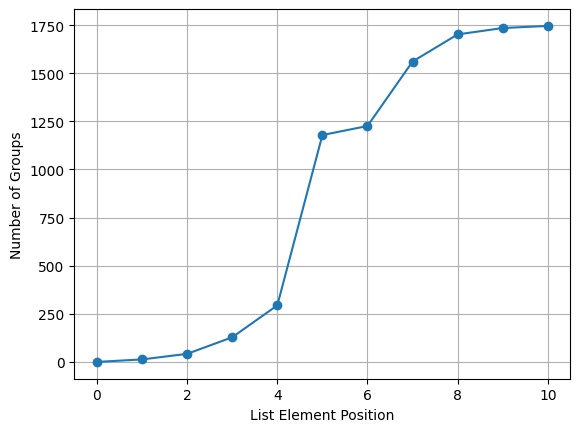

In [72]:
fig, ax = plt.subplots()
x = [0,1,2,3,4,5,6,7,8,9,10]
y = [0,13,42,128,294,1179,1226,1561,1702,1735,1746]
# ax.plt.figure(figsize=(6, 4))
plt.plot(x, y, marker='o')
# plt.plot(y)
ax.set(xlabel='List Element Position', ylabel='Number of Groups',
       title='')
ax.grid()
plt.show()

### Coloring

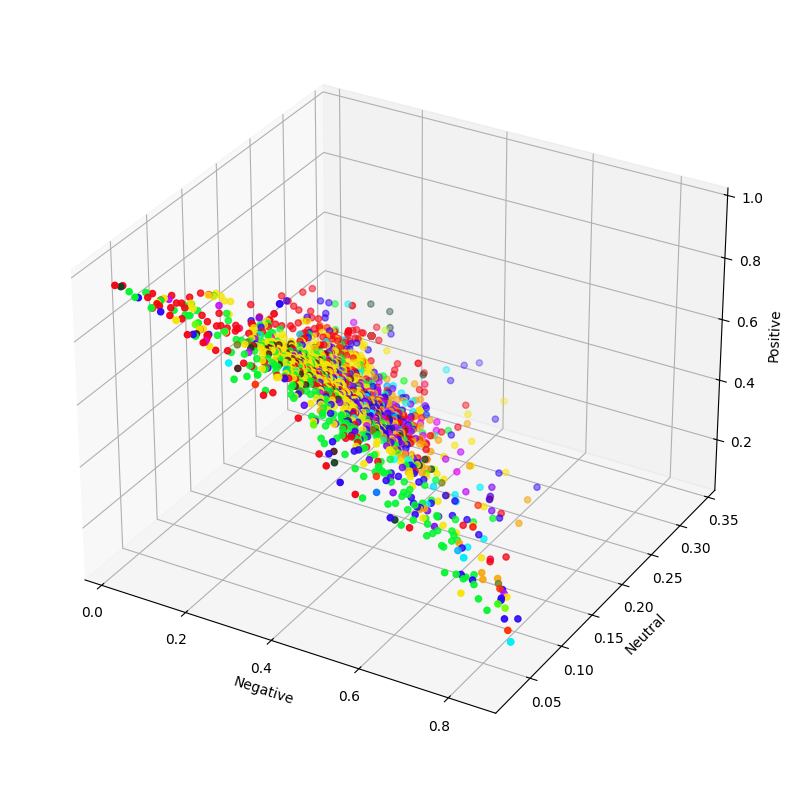

In [17]:
# specific_colors = {
#    13: "#f5e505", 11: "#05f531", 14: "#f50515", 8: "#2d05f7", 2: "#f5a505", 16: "#7c02f5", 4:"#c20aff", 12:"#4a1a1a", 7:"#02eff7", 10:"#144026", 32:"#79801d"
# }
# append_cluster_color(url_clustering_2, "group_id", specific_colors)

get_cluster_plot(url_clustering_2, "group_id")

# save_as_json(url_clustering_2, "url_clustering_2")

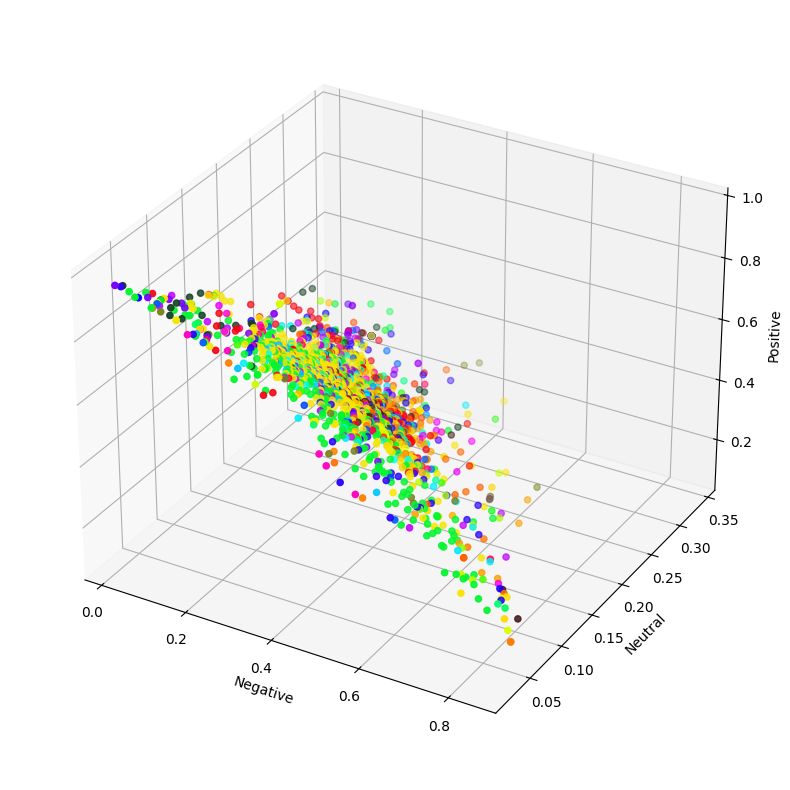

In [3]:
# specific_colors = {
#    176: "#f5e505", 166: "#05f531", 108: "#f50515", 90: "#2d05f7", 12: "#f5a505", 271: "#7c02f5", 283:"#c20aff", 20:"#4a1a1a", 99:"#02eff7", 162:"#144026", 69:"#79801d"
# }
# append_cluster_color(url_clustering_3, "group_id", specific_colors)

get_cluster_plot(url_clustering_3, "group_id")
# save_as_json(url_clustering_3, "url_clustering_3")

In [ ]:
url_clustering_2[url_clustering_2["group_id"]==12][["url_elements_list"]][:20]

In [91]:
url_clustering_3[url_clustering_3["group_id"]==90][["url_elements_list"]][:20]

,url_elements_list
193,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, loesungen-fuer-unternehmen]"
234,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, balanceakt-zwischen-arbeit-und-privatleben]"
235,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, eingliedern-statt-ausschliessen]"
268,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge]"
287,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, was-braucht-es-fuer-eine-erfolgreiche-weidereingliederung]"
290,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge]"
297,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, modulare-loesungen-fuer-pensionskassen]"
299,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, wie-steht-es-um-das-vertrauen-in-die-altersvorsorge]"
301,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, newsletter-berufliche-vorsorge]"
303,"[www.mobiliar.ch, versicherungen-und-vorsorge, angebote-fuer-unternehmen, berufliche-vorsorge, newsletter-berufliche-vorsorge, im-case-management-von-betroffenen-lernen]"


10 und 11 dürfen bei pos 3 nicht in der selben gruppe sein

In [83]:
url_clustering_3.iloc[[10]][["pagetitle","url_elements_list","group_id"]]
url_clustering_3.iloc[[25]][["pagetitle","url_elements_list","group_id"]]

,pagetitle,url_elements_list,group_id
25,Vor dem Umzug auch an die Versicherung gedacht?,"[www.mobiliar.ch, versicherungen-und-vorsorge, wohnen-und-eigentum, ratgeber, vor-dem-umzug-auch-an-die-versicherung-gedacht]",12


### Create Graph

In [93]:
# graph_url_clustering_3 = pd.read_json("../graph_network/url_clustering_3_04-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, url_clustering_3, "group_id") 
N.show("graph_url_clustering_3.html")

In [95]:
# graph_url_clustering_2 = pd.read_json("../graph_network/url_clustering_2_04-05-24.json")
G, N = get_graph_from_cluster_data_without_color(matrix, url_clustering_2, "group_id") 
N.show("graph_url_clustering_2.html")

### Cluster Analysis

In [10]:
def get_identical_url_elements_col(df, cluster_col, position):
    avg_senti_size_per_cluster = get_cluster_overview(df, "group_id")
    df = df[df[cluster_col].isin(avg_senti_size_per_cluster[cluster_col])]
    df['identical_url_elements'] = df['url_elements_list'].apply(lambda x: x[:position] if len(x) >= position else [None]*position)
    og_df = df.groupby(cluster_col).first().reset_index()
    avg_senti_size_per_cluster = pd.merge(avg_senti_size_per_cluster, og_df[[cluster_col, 'identical_url_elements']], on=cluster_col, how='left')
    avg_senti_size_per_cluster = avg_senti_size_per_cluster.sort_values("group_size", ascending=False)
    return avg_senti_size_per_cluster.reset_index()

In [17]:
df = get_cluster_overview(url_clustering_3, "group_id")
df[df["group_size"]>=10]

Number of Clusters that we can calculate the correlation: 60 
 containing: 1500 Pages/Nodes.


,group_id,avg_neg,avg_neu,avg_pos,group_size,color_group_id
41,176,0.303406,0.147707,0.548887,519,#f5e505
40,166,0.347778,0.118015,0.534207,252,#05f531
31,108,0.298415,0.162944,0.538642,84,#f50515
27,90,0.392231,0.153076,0.454693,61,#2d05f7
6,12,0.445147,0.172697,0.382155,56,#f5a505
56,271,0.270517,0.151591,0.577893,39,#7c02f5
57,283,0.306004,0.154578,0.539419,38,#c20aff
7,20,0.393783,0.162036,0.444181,37,#4a1a1a
30,99,0.314542,0.151035,0.534422,35,#02eff7
38,162,0.202366,0.142634,0.655000,33,#144026


In [18]:
df = get_identical_url_elements_col(url_clustering_3, "group_id", 4)
df.style.set_properties(subset=['identical_url_elements'], **{'text-align': 'left'})


Number of Clusters that we can calculate the correlation: 60 
 containing: 1500 Pages/Nodes.


/var/folders/z3/m0_jmm793c13j56bgg5x44dw0000gn/T/ipykernel_33630/3175240402.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['identical_url_elements'] = df['url_elements_list'].apply(lambda x: x[:position] if len(x) >= position else [None]*position)


,index,group_id,avg_neg,avg_neu,avg_pos,group_size,color_group_id,identical_url_elements
0,0,176,0.303406,0.147707,0.548887,519,#f5e505,"['www.mobiliar.ch', 'die-mobiliar', 'medien', 'medienmitteilungen']"
1,1,166,0.347778,0.118015,0.534207,252,#05f531,"['www.mobiliar.ch', 'die-mobiliar', 'nachhaltigkeit-engagement', 'das-gesellschaftsengagement-der-mobiliar']"
2,2,108,0.298415,0.162944,0.538642,84,#f50515,"['www.mobiliar.ch', 'die-mobiliar', 'ueber-uns', 'unternehmen-der-gruppe-mobiliar']"
3,3,90,0.392231,0.153076,0.454693,61,#2d05f7,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'angebote-fuer-unternehmen', 'berufliche-vorsorge']"
4,4,12,0.445147,0.172697,0.382155,56,#f5a505,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'wohnen-und-eigentum', 'ratgeber']"
5,5,271,0.270517,0.151591,0.577893,39,#7c02f5,"['www.mobiliar.ch', 'die-mobiliar', 'ueber-uns', 'geschaeftsbericht-2019']"
6,6,283,0.306004,0.154578,0.539419,38,#c20aff,"['www.mobiliar.ch', 'die-mobiliar', 'ueber-uns', 'geschaeftsbericht-2018']"
7,7,20,0.393783,0.162036,0.444181,37,#4a1a1a,"['www.mobiliar.ch', 'versicherungen-und-vorsorge', 'angebote-fuer-unternehmen', 'ratgeber']"
8,8,99,0.314542,0.151035,0.534422,35,#02eff7,"['www.mobiliar.ch', 'die-mobiliar', 'ueber-uns', 'unternehmensportraet']"
9,9,162,0.202366,0.142634,0.655000,33,#144026,"['www.mobiliar.ch', 'die-mobiliar', 'ueber-uns', 'sponsoring-und-events']"


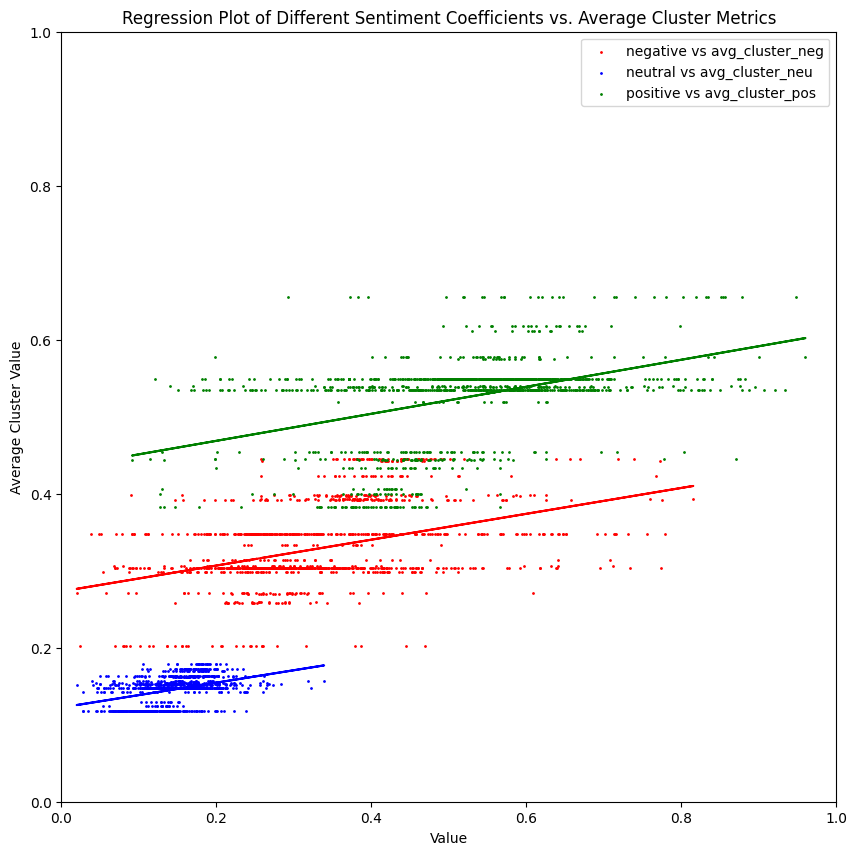

In [25]:
def plot_regression_multi(df):
    columns_pairs = [
        ("negative", "avg_cluster_neg", 'red'),
        ("neutral", "avg_cluster_neu", 'blue'),
        ("positive", "avg_cluster_pos", 'green')
    ]
    
    plt.figure(figsize=(10, 10))
    for x_col, y_col, color in columns_pairs:
        df_filtered = df.dropna(subset=[x_col, y_col])
        
        x = df_filtered[x_col]
        y = df_filtered[y_col]
        m, b = np.polyfit(x, y, 1)
        plt.scatter(x, y, color=color, label=f'{x_col} vs {y_col}', s=1)
        plt.plot(x, m*x + b, color=color)
    plt.xlabel('Value')
    plt.ylabel('Average Cluster Value')
    plt.title('Regression Plot of Different Sentiment Coefficients vs. Average Cluster Metrics')
    plt.legend()

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    
plot_regression_multi(append_mean_coefficients_per_cluster(url_clustering_3, "group_id"))

# Calculating the Correlation

In [8]:
get_mean_sentiment_corr(url_clustering_2, "group_id")

Num of Pages for Analysis:
 1591
Num of Clusters for Analysis:
 13


,negative,neutral,positive
avg_cluster_neg,0.390900,0.110600,-0.395513
avg_cluster_neu,0.116672,0.370557,-0.221508
avg_cluster_pos,-0.376997,-0.200150,0.410099


In [21]:
get_mean_sentiment_corr(url_clustering_3, "group_id")

Num of Pages for Analysis:
 1340
Num of Clusters for Analysis:
 20


,negative,neutral,positive
avg_cluster_neg,0.423186,0.100436,-0.418231
avg_cluster_neu,0.105733,0.401982,-0.218143
avg_cluster_pos,-0.407445,-0.201870,0.434388


In [22]:
get_mean_sentiment_corr(graph_clustering_shortest_path, "cluster_id")

Num of Pages for Analysis:
 1712
Num of Clusters for Analysis:
 11


,negative,neutral,positive
avg_cluster_neg,0.406102,0.057541,-0.396827
avg_cluster_neu,0.062621,0.373152,-0.177506
avg_cluster_pos,-0.389331,-0.160023,0.413921


In [6]:
get_mean_sentiment_corr(graph_clustering_e_b_c, "commun_id")

Num of Pages for Analysis:
 1693
Num of Clusters for Analysis:
 7


,negative,neutral,positive
avg_cluster_neg,0.349680,0.181175,-0.383038
avg_cluster_neu,0.217590,0.291159,-0.294868
avg_cluster_pos,-0.343628,-0.220260,0.389784


In [4]:
get_cluster_overview(url_clustering_2, "group_id")

Numbers of usable Clusters: 17 
 containing: 1612 Pages/Nodes.


,group_id,avg_neg,avg_neu,avg_pos,var_neg,var_neu,var_pos,group_size,color_group_id
9,13,0.303153,0.148598,0.548249,0.008514,0.001111,0.011378,527,#f5e505
7,11,0.345667,0.117823,0.536510,0.023000,0.001122,0.023625,257,#05f531
10,14,0.283021,0.152845,0.564135,0.014986,0.002803,0.021287,253,#f50515
4,8,0.397984,0.155039,0.446977,0.016998,0.001954,0.016799,195,#2d05f7
0,2,0.431127,0.171856,0.397017,0.009338,0.000823,0.007814,97,#f5a505
12,16,0.381694,0.155658,0.462648,0.008707,0.000811,0.008941,64,#7c02f5
1,4,0.390685,0.170080,0.439235,0.008721,0.000819,0.009704,52,#c20aff
8,12,0.265757,0.134153,0.600090,0.002148,0.000669,0.003222,49,#4a1a1a
3,7,0.433656,0.161298,0.405045,0.033033,0.002965,0.026293,32,#02eff7
6,10,0.364746,0.161259,0.473995,0.016583,0.004064,0.020269,26,#144026


In [22]:
df = get_cluster_overview(url_clustering_2, "group_id")
print("mean var_neg", round(df[df["group_size"]>=10]["var_neg"].mean(), 4))  #.sort_values("avg_neg")#.corr(numeric_only=True)
print("mean var_neu", round(df[df["group_size"]>=10]["var_neu"].mean(), 4))  #.sort_values("avg_neg")#.corr(numeric_only=True)
print("mean var_pos", round(df[df["group_size"]>=10]["var_pos"].mean(), 4))  #.sort_values("avg_neg")#.corr(numeric_only=True)

Numbers of usable Clusters: 17 
 containing: 1612 Pages/Nodes.
mean var_neg 0.0131
mean var_neu 0.0014
mean var_pos 0.014


In [21]:
df = get_cluster_overview(url_clustering_3, "group_id")
print("mean var_neg", round(df[df["group_size"]>=10]["var_neg"].mean(), 4))
print("mean var_neu", round(df[df["group_size"]>=10]["var_neu"].mean(), 4))
print("mean var_pos", round(df[df["group_size"]>=10]["var_pos"].mean(), 4))

Numbers of usable Clusters: 60 
 containing: 1500 Pages/Nodes.
mean var_neg 0.0108
mean var_neu 0.0016
mean var_pos 0.0125


In [20]:
df = get_cluster_overview(graph_clustering_e_b_c, "commun_id")
print("mean var_neg", round(df[df["commun_size"]>=10]["var_neg"].mean(), 4))
print("mean var_neu", round(df[df["commun_size"]>=10]["var_neu"].mean(), 4))
print("mean var_pos", round(df[df["commun_size"]>=10]["var_pos"].mean(), 4))

Numbers of usable Clusters: 15 
 containing: 1713 Pages/Nodes.
mean var_neg 0.0147
mean var_neu 0.0019
mean var_pos 0.0148


In [19]:
df = get_cluster_overview(graph_clustering_shortest_path, "cluster_id")
print("mean var_neg", round(df[df["cluster_size"]>=10]["var_neg"].mean(), 4))
print("mean var_neu", round(df[df["cluster_size"]>=10]["var_neu"].mean(), 4))
print("mean var_pos", round(df[df["cluster_size"]>=10]["var_pos"].mean(), 4))

Numbers of usable Clusters: 12 
 containing: 1718 Pages/Nodes.
mean var_neg 0.0143
mean var_neu 0.0019
mean var_pos 0.0148


In [36]:
def get_usable_clusters(df, cluster_col, coefficient_names):
    std_dev = df.groupby(cluster_col)[coefficient_names].std()
    return std_dev[(std_dev["neutral"].notnull()) & (std_dev["neutral"] != 0)]

# df = graph_clustering_e_b_c
cluster_col = "group_id"

def get_filtered_df(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]
    usable_values = get_usable_clusters(df, cluster_col, coefficient_names)
    cluster_sizes = df[cluster_col].value_counts()
    large_clusters = cluster_sizes[cluster_sizes >= 10].index
    return df[(df[cluster_col].isin(usable_values.index)) & (df[cluster_col].isin(large_clusters))][['negative', 'neutral', 'positive', cluster_col, f'color_{cluster_col}']]
    
df = get_filtered_df(url_clustering_3, "group_id")

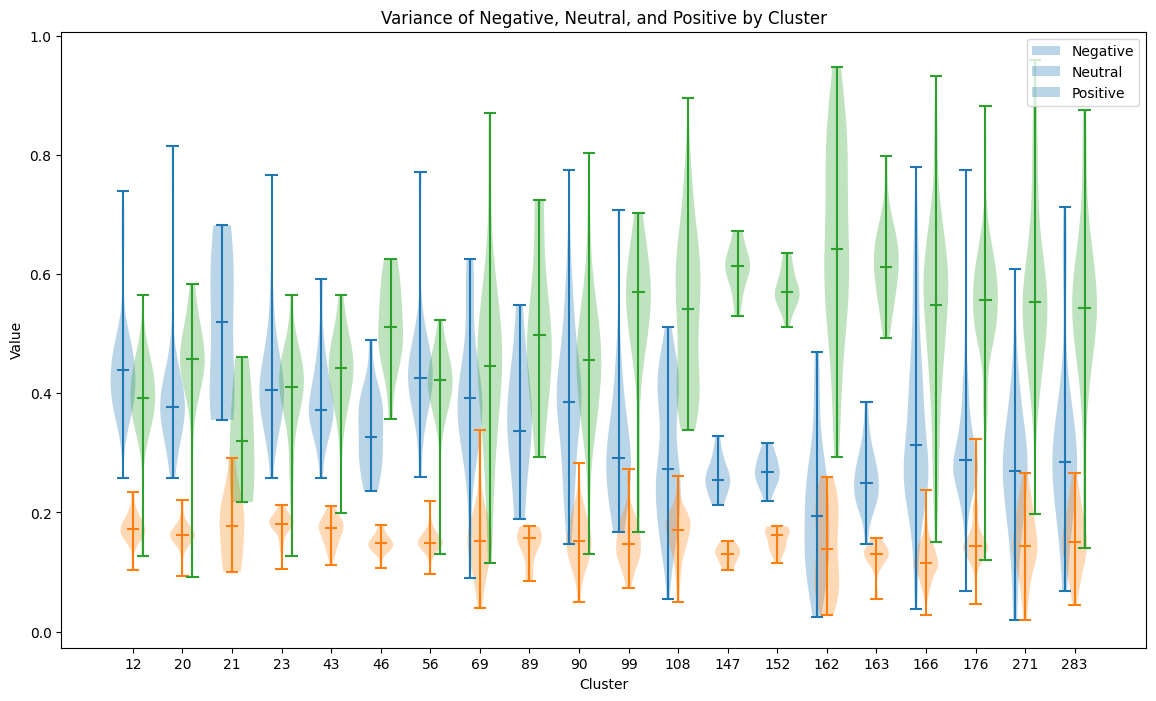

In [37]:
groups = df[cluster_col].unique()
negative_data = [df[df[cluster_col] == group]['negative'] for group in groups]
neutral_data = [df[df[cluster_col] == group]['neutral'] for group in groups]
positive_data = [df[df[cluster_col] == group]['positive'] for group in groups]

# Violinplot erstellen
fig, ax = plt.subplots(figsize=(14, 8))

positions = np.arange(len(groups))
width = 0.2

ax.violinplot(negative_data, positions=positions - width, showmeans=False, showmedians=True)
ax.violinplot(neutral_data, positions=positions, showmeans=False, showmedians=True)
ax.violinplot(positive_data, positions=positions + width, showmeans=False, showmedians=True)

# Anpassungen für bessere Lesbarkeit
ax.set_xticks(positions)
ax.set_xticklabels(groups)
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Value')
ax.set_title('Variance of Negative, Neutral, and Positive by Cluster')
ax.legend(['Negative', 'Neutral', 'Positive'])

plt.show()

In [33]:
graph_clustering_e_b_c.shape[0]

1718

Numbers of usable Clusters: 60 
 containing: 1500 Pages/Nodes.


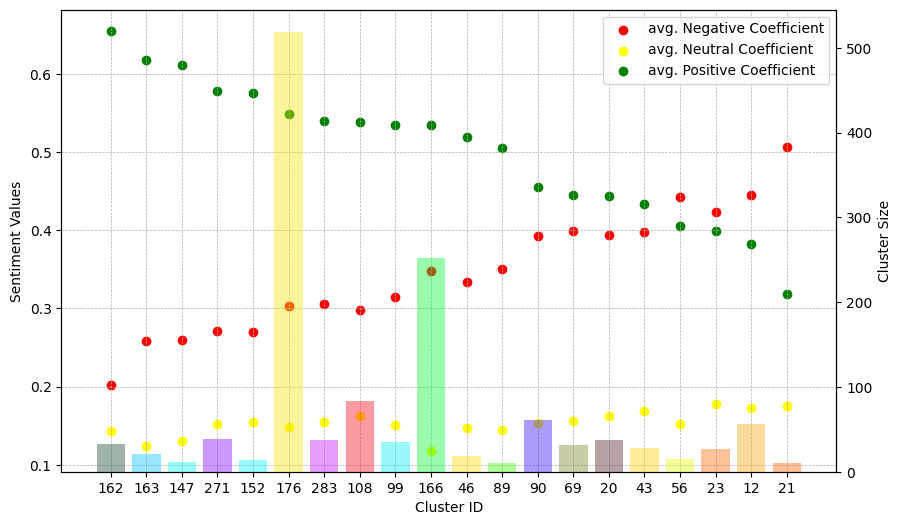

In [26]:
def get_overview_plot(df, cluster_col):
    df = get_cluster_overview(df, cluster_col)
    df = df[df[f"{cluster_col[:-3]}_size"]>=10].sort_values("avg_pos", ascending=False)
    df[cluster_col] = df[cluster_col].astype(str)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for group in df[cluster_col].unique():
        group_data = df[df[cluster_col] == group]
        ax1.scatter([group]*len(group_data), group_data['avg_neg'], color='red', label='avg. Negative Coefficient' if group == df[cluster_col].unique()[0] else "")
        ax1.scatter([group]*len(group_data), group_data['avg_neu'], color='yellow', label='avg. Neutral Coefficient' if group == df[cluster_col].unique()[0] else "")
        ax1.scatter([group]*len(group_data), group_data['avg_pos'], color='green', label='avg. Positive Coefficient' if group == df[cluster_col].unique()[0] else "")

    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Sentiment Values')
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax2 = ax1.twinx()
    ax2.bar(df[cluster_col], df[f"{cluster_col[:-3]}_size"], color=df[f"color_{cluster_col}"], alpha=0.4, width=0.8)
    ax2.set_ylabel('Cluster Size')

get_overview_plot(url_clustering_3, "group_id")

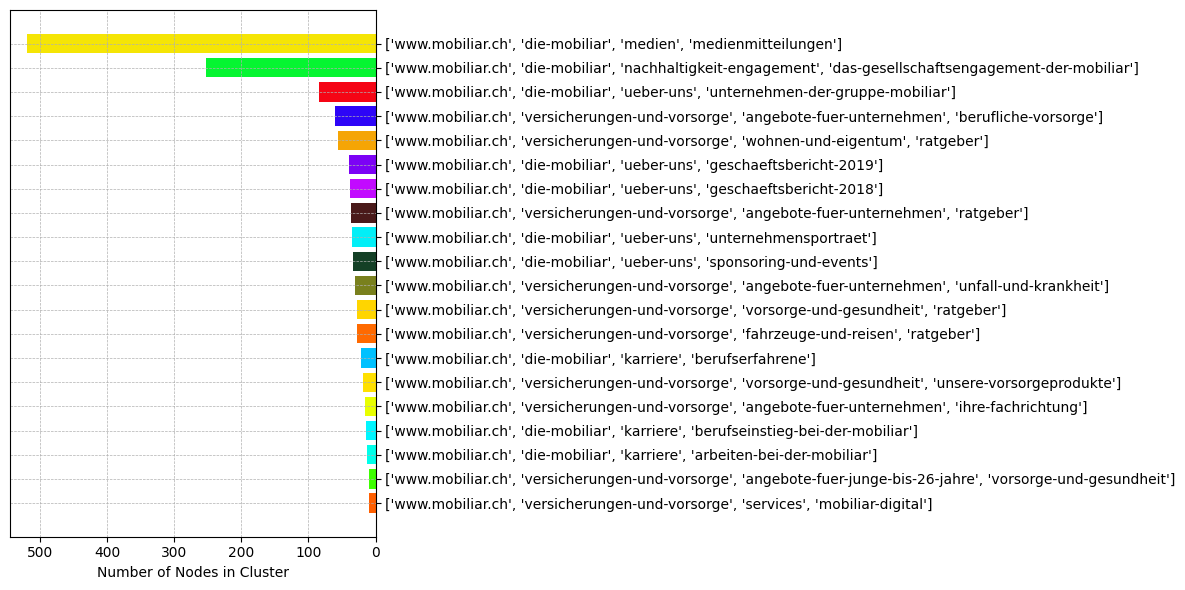

In [26]:
def get_bar_plot(df, cluster_col):  
    plt.figure(figsize=(12, 6))  # Größe des Plots festlegen
    plt.barh(df['identical_url_elements'].astype(str), df[f'{cluster_col[:-3]}_size'], color=df[f"color_{cluster_col}"])

    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.xlabel(f'Number of Nodes in Cluster') #{cluster_col[:-3]}
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    # yaxis.set_label_position("right")
    ax = plt.gca()  # Aktuelle Achse holen
    ax.yaxis.set_label_position("right")  # Position des Y-Achsen-Labels setzen
    ax.yaxis.tick_right()
    plt.show()

get_bar_plot(df, "group_id")

In [17]:
df = get_cluster_overview(url_clustering_3, "group_id")
df[df["group_size"]>=10].sort_values("avg_neg", ascending=False)

Number of Clusters that we can calculate the correlation: 60 
 containing: 1500 Pages/Nodes.


,group_id,avg_neg,avg_neu,avg_pos,group_size,color_group_id
8,21,0.506382,0.174924,0.318694,10,#ff5f00
6,12,0.445147,0.172697,0.382155,56,#f5a505
19,56,0.441853,0.152296,0.405852,15,#e8ff00
9,23,0.422593,0.178324,0.399083,27,#ff6a00
23,69,0.398479,0.156275,0.445246,31,#79801d
13,43,0.397094,0.169381,0.433525,28,#ffd500
7,20,0.393783,0.162036,0.444181,37,#4a1a1a
27,90,0.392231,0.153076,0.454693,61,#2d05f7
26,89,0.350393,0.145070,0.504538,10,#3dff00
40,166,0.347778,0.118015,0.534207,252,#05f531


##### most positive cluster:

In [137]:
most_positive_idx = df[df["group_size"]>=10][["avg_neg","avg_pos"]].diff(axis=1)["avg_pos"].idxmax()
most_positive = df.loc[most_positive_idx, 'group_id']
most_positive

162

In [141]:
df[df["group_id"]==most_positive]

,group_id,avg_neg,avg_neu,avg_pos,group_size,color_group_id
38,162,0.202366,0.142634,0.655,33,#144026


In [146]:
url_clustering_3[url_clustering_3["group_id"]==147][["url_elements_list"]][:10]

,url_elements_list
392,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, teilzeit-bei-der-mobiliar]"
394,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, arbeitskultur]"
395,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, anstellungsbedingungen]"
396,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, mikado]"
398,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, diversitaet]"
510,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, aus-und-weiterbildung-bei-der-mobiliar]"
511,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, agilitaet-bei-der-mobiliar]"
529,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, mikado, anmeldung-mikado]"
602,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, aus-und-weiterbildung-bei-der-mobiliar, cicero-beratungsqualitaet-und-weiterbildung]"
1011,"[www.mobiliar.ch, die-mobiliar, karriere, arbeiten-bei-der-mobiliar, transparenz-im-bewerbungsprozess]"


##### most negative

In [152]:
most_negative_idx = df[df["group_size"]>=10][["avg_neg","avg_pos"]].diff(axis=1)["avg_pos"].idxmin()
most_negative = df.loc[most_negative_idx, 'group_id']
most_negative

21

In [153]:
df[df["group_id"]==most_negative]

,group_id,avg_neg,avg_neu,avg_pos,group_size,color_group_id
8,21,0.506382,0.174924,0.318694,10,#ff5f00


In [1]:
url_clustering_3[url_clustering_3["group_id"]==12][["url_elements_list"]][:10]

NameError: name 'url_clustering_3' is not defined

In [164]:
senti.shape[0]
# .filter(items=[23], axis=0)


1746